# Setup
In this Section, the required packages and relevant dataset(s) are imported.

In [98]:
# Import of required packages
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline

# Import of required datasets
survey_results = pd.read_csv('./survey_results_public.csv')
survey_schema = pd.read_csv('./survey_results_schema.csv')

The column "Respondent" is dropped immediately, being just an identifier of the people who filled the questionnaire in, hence not usable for any models we want to explore.

In [99]:
# Preliminary transformation of the data: Column "Respondent" dropped
survey_results = survey_results.drop('Respondent', axis = 1)

# Question 1
## Is it possible to create a model that foresee the Salary of an individual based only on the categorical variables who have not any missing values in the Dataset?

### Wrangling of Data

First, we divide our Dataset into categorical and numerical variables.

In [100]:
# Categorical Variables
cat_survey_results = survey_results.select_dtypes(include=['object'])

# Numerical Variables
num_survey_results = survey_results.select_dtypes(include = ['int', 'float'])

From the subset of categorical variables, we select the ones who have not any missing values.

In [101]:
full_cat_survey_results = cat_survey_results.columns[cat_survey_results.isnull().mean()==0]
full_cat_survey_results


Index(['Professional', 'ProgramHobby', 'Country', 'University',
       'EmploymentStatus', 'FormalEducation'],
      dtype='object')

### Linear Regression

We first split our Dataset in input (X) and output (y) variables: the input will be the six categorical variables previously identified which have not any missing values in the Dataset.

In [103]:
fit1 = survey_results[['Salary', 'Country', 'EmploymentStatus', 'FormalEducation', 'ProgramHobby', 'Professional','University']]
fit1.shape

(51392, 7)

For the output variable (y = Salary) that we want to predict, we drop the records for which we do not have any values in the Dataset.

In [104]:
fit1 = fit1.dropna(subset = ['Salary'], axis = 0)
fit1.shape

(12891, 7)

We build now the linear model for regression:

In [105]:
# X = input variables (i.e. categorical variables), y = output variable (i.e. Salary)
X = fit1[['Country','EmploymentStatus', 'FormalEducation', 'ProgramHobby', 'Professional', 'University']]
y = fit1.Salary

# Categorical input variables are transformed
for var in full_cat_survey_results:
    X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
# Division of input data into Train and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

# Creation of the Regression Model
lm_model = make_pipeline(StandardScaler(), LinearRegression())

#Fit
lm_model.fit(X_train, y_train) 

#Predict on both, Train and Test data
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

Before analysing the results of the regression, we check that all data (12.891 data points) have been used for both, input and output of the model.

In [106]:
# Check on Input data
if X_train.shape[0] + X_test.shape[0] - fit1.shape[0] == 0:
    print ("All input data points have been used.")
else:
    print ("Something wrong has happened.")

# Check on Output data
if y_test_preds.shape[0] + y_train_preds.shape[0] - fit1.shape[0] == 0:
    print ("All output data points have been used.")
else:
    print ("Something wrong has happened.")

All input data points have been used.
All output data points have been used.


Now that we know that the linear regression model has worked properly, we can analyse the results of the fit for both, test and training sets.

In [107]:
# Result of the fitting on test set data
"The r-squared score for the model using only categorical variables which do not contain any missing values, on the test set of data, was {} on {} values.".format(test_score, len(y_test))

'The r-squared score for the model using only categorical variables which do not contain any missing values, on the test set of data, was -1.5782894991941965e+21 on 3868 values.'

In [108]:
# Result of the fitting on trainign set data
"The r-squared score for the model using only categorical variables which do not contain any missing values, on the training set of data, was {} on {} values.".format(train_score, len(y_train))

'The r-squared score for the model using only categorical variables which do not contain any missing values, on the training set of data, was 0.6170606739678997 on 9023 values.'

Both fittings are not satisfying. On training data, R2 is too low to confirm with statistical significance that the model works properly (one would expect and R2 close to 1 on training data); on test data, the R2 is negative, leading to the conclusion that a linear regression does not capture properly the correlation between input and output variables. We therefore conclude that the categorical variables used to predict the salary of the respondents to the survey are not enough to predict properly their salaries.

# Question 2

## Is it possible to reduce the dimensionality of our problem (predicting salaries based on other factors), and is there a relation between dimensionality and number of features used?

In order to answer to this question, we need to proceed with two steps: i) Reduction of features for the linear model, ii) Principal Component Analysis.

i) Reduction of features: we aim at using only part of the input variables (numerical and categorical ones), by selecting from 1 to a certain amount (in this case, 11.000) input variables, to predict the salaries of the respondent to the survey.

ii) Principal Component Analysis: without getting too much into details about this tool, we will apply a PCA to our (reduced - see bullet point above) set of input variables, to "transform" the dataset of input variables itself. Result of this PCA is the definition of a new set of input data, which is a linear combination of the original input variables.

By combining i) and ii), we asses the relation between the number of original input variables (features) to be used for the PCA and the number of components (i.e., "new" input variables, which are a linear combination of the original set of input variables) of the PCA itself: to do so, we focus on the "Expected Variance" of the PCA, i.e. the amount of variation of the output variable described by the new components of the PCA.

### Helper Functions

In [70]:
# This function aims at reducing the number of input variables by "cutting them off" from the model. 
# Input: "cutoff" = number of variables to consider; "X" = input variables; "y" = output variable(s)
# Output: "X_train" = train set of input variables, reduced, to be used for our model
def runCutoff(cutoff, X, y):
    reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
    reduce_X = StandardScaler().fit_transform(reduce_X)
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = .30, random_state=42)
    return X_train

# This function gives the Explained Variance of the PCA, based on the input variables given to the PCA function itself
# Input: "X" = input variables (in our case, the reduced set of X_train from the previous function); "n_components" = number of
# components (i.e. linear combination of reduced input variables) that constitute the PCA
# Output: cumulative sum of the Explained Variance of each component of the PCA
def pcaExplainedVariance (X, n_components):
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components = n_components)
    X = pca.fit_transform(X)
    return sum(pca.explained_variance_ratio_)

# This function joins the "runCutoff" function with the "pcaExplainedVariance" one, and creates a matrix of results where
# for each line (= number of components of the PCA) we have the Explained Variance with different amount of features used
# Input: "X" = input variables; "y" = output variable(s); "maxCutoff" = maximum amount of input variables to be used;
# "stepCutoff" = how many new features we will include during a new iteration of the PCA; "n_components" = number of
# components of the PCA
# Output: "results" matrix having #rows = "n_components", #columns = maxCutoff/stepCutoff
def plotPCACutoffs(X, y, maxCutoff, stepCutoff, n_components):
    cutoffs = range(0, maxCutoff, stepCutoff)
    results = np.zeros((n_components, mt.ceil(maxCutoff/stepCutoff)))
    for i in range(1, n_components + 1):
        iter = 0
        for j in cutoffs:
            results[i-1, iter] = pcaExplainedVariance(runCutoff(j, X, y), i) * 100
            iter = iter + 1  
    return results

### Wrangling of Data

We divide the original dataset into input (X) and output (y) variables.

In [71]:
# Definition of the output variable of the model, "Salary". 
# We focus on the records for both, input and output sets of data, where "Salary" is filled in
fit2 = survey_results.dropna(subset = ['Salary'], axis = 0)
y = fit2.Salary
fit2 = fit2.drop(['ExpectedSalary','Salary'], axis=1)

# The numerical input variables for which no data is present are filled in with the mean of the column itself
num_survey_results_columns = num_survey_results.drop(['ExpectedSalary','Salary'],axis=1).columns
for col in num_survey_results_columns:
    fit2[col].fillna((fit2[col].mean()), inplace=True)
    
# Categorical input variables are transformed
cat_survey_results_columns = cat_survey_results.columns
for var in  cat_survey_results_columns:
    fit2 = pd.concat([fit2.drop(var, axis=1), pd.get_dummies(fit2[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

X = fit2

### Expected Variance as a function of number of components and number of features

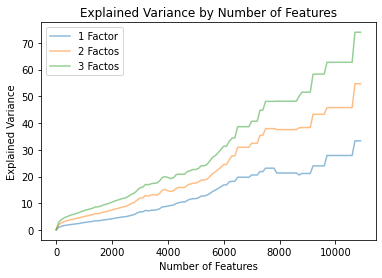

In [72]:
# Input for the helper functions
maxCutoff = 11000
stepCutoff = 100
n_components = 3
cutoffs = range(0, maxCutoff, stepCutoff)

# PCA and PCA results (Explained Variance by number of components and features)
results = plotPCACutoffs(X = X, y = y, maxCutoff = maxCutoff, stepCutoff = stepCutoff, n_components = n_components)

# Plot
plt.plot(cutoffs, results[0,:], label="1 Factor", alpha=.5)
plt.plot(cutoffs, results[1,:], label="2 Factos", alpha=.5)
plt.plot(cutoffs, results[2,:], label="3 Factos", alpha=.5)
plt.xlabel('Number of Features')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Number of Features')
plt.legend(loc=2)
plt.show()

The results of this function are more surprising than expected: if, on one side, in fact, we do see an increase in the Expected Variance by increasing number of features and factors/components, on the other side even with three principal components "only" 70% of the variance of the output variable can be explained. This is quite indicative of the lack of robustness/predictive power of the model.


# Question 3

## Is the Expected Salary a more predictable indicator than the Salary?

To answer this question, we repeat the steps performed above in terms of i) Wrangling of Data, ii) Linear Interpolation, iii) Principal Components Analysis.

### Wrangling of Data

In [73]:
# Definition of the output variable of the model, "ExpectedSalary". 
# We focus on the records for both, input and output sets of data, where "ExpectedSalary" is filled in
fit3 = survey_results.dropna(subset = ['ExpectedSalary'], axis = 0)
y = fit3.ExpectedSalary
fit3 = fit3.drop(['Salary'], axis=1)

# The numerical input variables for which no data is present are filled in with the mean of the column itself
num_survey_results_columns = num_survey_results.drop(['Salary', 'ExpectedSalary'],axis=1).columns
for col in num_survey_results_columns:
    fit3[col].fillna((fit3[col].mean()), inplace=True)
    
# Categorical input variables are transformed
cat_survey_results_columns = cat_survey_results.columns
for var in  cat_survey_results_columns:
    fit3 = pd.concat([fit3.drop(var, axis=1), pd.get_dummies(fit3[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

X = fit3

In [74]:
# Division of input data into Train and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

# Creation of the Regression Model
lm_model = make_pipeline(StandardScaler(), LinearRegression())

#Fit
lm_model.fit(X_train, y_train) 

#Predict on both, Train and Test data
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

### Linear Regression

In [75]:
# Division of input data into Train and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

# Creation of the Regression Model
lm_model = make_pipeline(StandardScaler(), LinearRegression())

#Fit
lm_model.fit(X_train, y_train) 

#Predict on both, Train and Test data
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [76]:
# Check on Input data
if X_train.shape[0] + X_test.shape[0] - fit3.shape[0] == 0:
    print ("All input data points have been used.")
else:
    print ("Something wrong has happened.")

# Check on Output data
if y_test_preds.shape[0] + y_train_preds.shape[0] - fit3.shape[0] == 0:
    print ("All output data points have been used.")
else:
    print ("Something wrong has happened.")

All input data points have been used.
All output data points have been used.


In [77]:
# Result of the fitting on test set data
"The r-squared score for the model using only categorical variables which do not contain any missing values, on the test set of data, was {} on {} values.".format(test_score, len(y_test))

'The r-squared score for the model using only categorical variables which do not contain any missing values, on the test set of data, was 0.730647149465175 on 770 values.'

In [78]:
# Result of the fitting on trainign set data
"The r-squared score for the model using only categorical variables which do not contain any missing values, on the training set of data, was {} on {} values.".format(train_score, len(y_train))

'The r-squared score for the model using only categorical variables which do not contain any missing values, on the training set of data, was 1.0 on 1796 values.'

### Principal Components Analysis

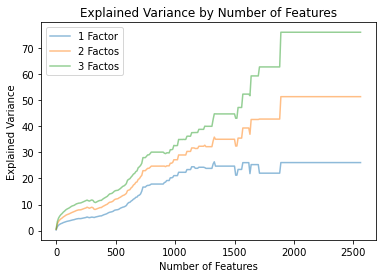

In [79]:
# Input for the helper functions
maxCutoff = 2570
stepCutoff = 10
n_components = 3
cutoffs = range(0, maxCutoff, stepCutoff)

# PCA and PCA results (Explained Variance by number of components and features)
results = plotPCACutoffs(X = X, y = y, maxCutoff = maxCutoff, stepCutoff = stepCutoff, n_components = n_components)

# Plot
plt.plot(cutoffs, results[0,:], label="1 Factor", alpha=.5)
plt.plot(cutoffs, results[1,:], label="2 Factos", alpha=.5)
plt.plot(cutoffs, results[2,:], label="3 Factos", alpha=.5)
plt.xlabel('Number of Features')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Number of Features')
plt.legend(loc=2)
plt.show()

The results of the interpolation are again surprising, in fact i) With less input data records (770 test data, plus 1796 train data) the interpolation grants a better fitting between Expected Salary and all the other numerical (but Salary) and categorical values; ii) despite that, the analysis of the Expected Variance of the PCA with different features and principal components results in what already found answering Question 2, i.e. that no more than 70% of the Expected Variance of the ouput variable (Expected Salary) can be explained by the model. For the latter, observing this kind of behaviour for different models may suggest that the issue in the explanation of the output variable's variance would depend not on the model itself/data points used/input variables, but possibly on "how" the input variables are treated in the model (for both cases, missing values were filled in with the mean of the column itself).